In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
#import astromet
import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import scanninglaw.times
from scanninglaw.source import Source
import h5py
import seaborn as sns

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=1
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=10
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 37.616 s
  auxilliary:  19.167 s
          sf:   5.954 s
interpolator:  12.495 s


In [5]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [354]:
gums_file='data/gums_sample_reparameterised_200pc.h'

with h5py.File(gums_file, 'r') as f:
    gums = {}
    for key in f.keys():
        gums[key] = f[key][...]
print('\n',gums.keys())
print(gums['system_id'])
print(gums['system_id'].size)

delta_file='data/gums_fits_dr2&3_200pc.h'

with h5py.File(delta_file, 'r') as f:
    delta = {k:v[:] for k,v in f.items()}
print('\n',delta.keys())
print(delta['system_id'])
print(delta['system_id'].size)


 dict_keys(['a', 'age', 'alphafe', 'barycentric_distance', 'binary', 'dec', 'e', 'feh', 'inclination', 'l', 'longitude_ascending_node', 'parallax', 'periastron_argument', 'period', 'pmdec', 'pmra', 'population', 'primary_hr_class', 'primary_logg', 'primary_mag_bp', 'primary_mag_g', 'primary_mag_rp', 'primary_mag_rvs', 'primary_mass', 'primary_mean_absolute_v', 'primary_radius', 'primary_spectral_type', 'primary_teff', 'primary_v_i', 'q', 'ra', 'radial_velocity', 'secondary_hr_class', 'secondary_logg', 'secondary_mag_bp', 'secondary_mag_g', 'secondary_mag_rp', 'secondary_mag_rvs', 'secondary_mass', 'secondary_mean_absolute_v', 'secondary_radius', 'secondary_spectral_type', 'secondary_teff', 'secondary_v_i', 'system_id', 'tperi', 'unresolved', 'vomega', 'vphi', 'vtheta'])
[b'*134218291-000155' b'*134218961-004968' b'*134219086-000004' ...
 b'*268435169-000002' b'*268435252-000002' b'*268435449-000001']
882107

 dict_keys(['UWE_dr2', 'UWE_edr3', 'astrometric_chi2_al_dr2', 'astrometric_ch

In [355]:
# single star data
singles=np.flatnonzero(gums['binary']==False)

sras=gums['ra'][singles]
sdecs=gums['dec'][singles]
spmras=gums['pmra'][singles]
spmdecs=gums['pmdec'][singles]
spllxs=1000/gums['barycentric_distance'][singles]
smags=gums['primary_mag_g'][singles]

In [356]:
# binary star data
binaries=np.flatnonzero(gums['binary']==True)

pllxs=1000/gums['barycentric_distance'] # mas
semis=gums['a'] # au
eccs=gums['e']
# randomly generating viewing angles because I got too confused by the argument of pericentre
vthetas=gums['vtheta']#np.arccos(-1+2*np.random.rand(pllxs.size)) # rad
vphis=gums['vphi']#2*np.pi*np.random.rand(pllxs.size) # rad
vomegas=gums['vomega']#2*np.pi*np.random.rand(pllxs.size) # rad

periods=gums['period']#gums['orbit_period']/astromet.T # years

tperis=gums['tperi']#2016+gums['periastron_date']/astromet.T
ptot_mags=gums['primary_mag_g']
stot_mags=gums['secondary_mag_g']
tot_mags=ptot_mags
tot_mags[binaries]=-2.5*np.log10(10**(-0.4*ptot_mags[binaries])+10**(-0.4*stot_mags[binaries]))
atot_mags=tot_mags - 5 + 5*np.log10(pllxs)
aptot_mags=ptot_mags - 5 + 5*np.log10(pllxs)
astot_mags=stot_mags - 5 + 5*np.log10(pllxs)
bps=-2.5*np.log10(10**(-0.4*gums['primary_mag_bp'])+10**(-0.4*gums['secondary_mag_bp']))
rps=-2.5*np.log10(10**(-0.4*gums['primary_mag_rp'])+10**(-0.4*gums['secondary_mag_rp']))
pcols=gums['primary_mag_bp']-gums['primary_mag_rp']
scols=gums['secondary_mag_bp']-gums['secondary_mag_rp']
cols=bps-rps
ls=gums['l']#10**(0.4*(gums['primary_mag_g']-gums['secondary_mag_g']))
qs=gums['q']#gums['secondary_mass']/gums['primary_mass']

#misordered=np.flatnonzero(ls>1)
#ls[misordered]=1/ls[misordered]
#qs[misordered]=1/qs[misordered]
#deltas=np.abs(qs-ls)/((1+ls)*(1+qs))

max_proj_sep=semis*pllxs*(1+eccs)*np.cos(vthetas)

ubins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180) & (periods<100)) # unresolved binaries
ualtbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180))
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180)) # (partially) resolved binaries
nall=gums['ra'].size
nsingle=singles.size
nbinary=ubins.size
nother=nall-nsingle-nbinary


print(nall,' sources in 100 pc')
print(nsingle,' single sources')
print(nbinary,' unresolved binaries w. period < 100 years')
print(nother,' other sources')
print('(',ualtbins.size,' all unresolved binaries)')


uids=gums['system_id'][ubins]

uras=gums['ra'][ubins]
udecs=gums['dec'][ubins]
upmras=gums['pmra'][ubins]
upmdecs=gums['pmdec'][ubins]
upllxs=pllxs[ubins]

uperiods=periods[ubins]
uas=semis[ubins]
ues=eccs[ubins]

uls=ls[ubins]
uqs=qs[ubins]
udeltas=(np.abs(qs-ls)/((1+ls)*(1+qs)))[ubins]
utperis=tperis[ubins]

uvthetas=vthetas[ubins]
uvphis=vphis[ubins]
uvomegas=vomegas[ubins]

umags=tot_mags[ubins]
uamags=atot_mags[ubins]
ucols=cols[ubins]

puamags=aptot_mags[ubins]
pucols=pcols[ubins]

suamags=astot_mags[ubins]
sucols=scols[ubins]

882107  sources in 100 pc
638730  single sources
107775  unresolved binaries w. period < 100 years
135602  other sources
( 188006  all unresolved binaries)


In [357]:
print(qs.size)
print(np.flatnonzero(qs==1).size)
print(np.flatnonzero(ls==1).size)
print(np.flatnonzero((ls==1) & (qs==1)).size)
print(np.flatnonzero(ls==qs).size)

882107
6923
3866
3866
3866


In [358]:
delta_arr = np.array([delta['system_id'][i][:-1] for i in range(len(delta['system_id']))])
gums_arr = np.array([gums['system_id'][i] for i in range(len(gums['system_id']))])

fuwes=delta['UWE_edr3']
fras=delta['ra_edr3']
fraerrs=delta['ra_error_edr3']
fdecs=delta['dec_edr3']
fdecerrs=delta['dec_error_edr3']
fpllxs=delta['parallax_edr3']
fpllxerrs=delta['parallax_error_edr3']
fpmras=delta['pmra_edr3']
fpmraerrs=delta['pmra_error_edr3']
fpmdecs=delta['pmdec_edr3']
fpmdecerrs=delta['pmdec_error_edr3']
fmaxseps=delta['max_seperation_edr3']
fminseps=delta['min_seperation_edr3']
fmaxrvs=delta['max_rv_edr3']
fminrvs=delta['min_rv_edr3']
fdpms=np.sqrt((fpmras-delta['pmra_dr2'])**2 + (fpmdecs-delta['pmdec_dr2'])**2)
fdpm_errs=np.sqrt((fpmras-delta['pmra_dr2'])**2 * (fpmraerrs**2 + delta['pmra_error_dr2']**2)\
        +(fpmdecs-delta['pmdec_dr2'])**2 * (fpmdecerrs**2 + delta['pmdec_error_dr2']**2))/fdpms
fdrvs=fmaxrvs-fminrvs

# inidices to pick out single stars
_,fsingles,_ = np.intersect1d(delta_arr, gums_arr[singles.astype(int)], return_indices=True)
_,fbinaries,_ = np.intersect1d(delta_arr, gums_arr[ubins.astype(int)], return_indices=True)
_,fallbinaries,_ = np.intersect1d(delta_arr, gums_arr[binaries.astype(int)], return_indices=True)

In [359]:
# classifying sources by their position on the HR diagram 
# as a combined source, and as primary and secondary

wdsel=np.flatnonzero((ucols<2) & (uamags > 4 + 5*ucols) & (uamags > 4))
lmssel=np.flatnonzero((ucols>2) & (uamags > 14))
giantsel=np.flatnonzero((uamags < 4) & (ucols>1))
ymssel=np.flatnonzero((uamags < 4) & (ucols<1))
mssel=np.flatnonzero((uamags > 4) & (uamags < 14)
           & (uamags < 4 + 5*ucols))
#source classification - 0=MS, 1=YMS, 2=Giant, 3=lms, 4=WD
combclass=np.zeros(ucols.size)
combclass[ymssel]=1
combclass[giantsel]=2
combclass[lmssel]=3
combclass[wdsel]=4
combclass=combclass.astype(int)

wdprim=np.flatnonzero((pucols<2) & (puamags > 4 + 5*pucols) & (puamags > 4))
lmsprim=np.flatnonzero((pucols>2) & (puamags > 14))
giantprim=np.flatnonzero((puamags < 4) & (pucols>1))
ymsprim=np.flatnonzero((puamags < 4) & (pucols<1))
msprim=np.flatnonzero((puamags > 4) & (puamags < 14)
           & (puamags < 4 + 5*pucols))

primclass=np.zeros(ucols.size).astype(int)
primclass[ymsprim]=1
primclass[giantprim]=2
primclass[lmsprim]=3
primclass[wdprim]=4
primclass=primclass.astype(int)

wdsec=np.flatnonzero((sucols<2) & (suamags > 4 + 5*sucols) & (suamags > 4))
lmssec=np.flatnonzero((sucols>2) & (suamags > 14))
giantsec=np.flatnonzero((suamags < 4) & (sucols>1))
ymssec=np.flatnonzero((suamags < 4) & (sucols<1))
mssec=np.flatnonzero((suamags > 4) & (suamags < 14)
           & (suamags < 4 + 5*sucols))

secclass=np.zeros(ucols.size).astype(int)
secclass[ymssec]=1
secclass[giantsec]=2
secclass[lmssec]=3
secclass[wdsec]=4
secclass=secclass.astype(int)

classcols=np.array(['#fb8500','#219ebc','#d62828','#6a040f','#8ecae6'])
classnames=['MS','YMS','Giants','LMS','WDs']

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


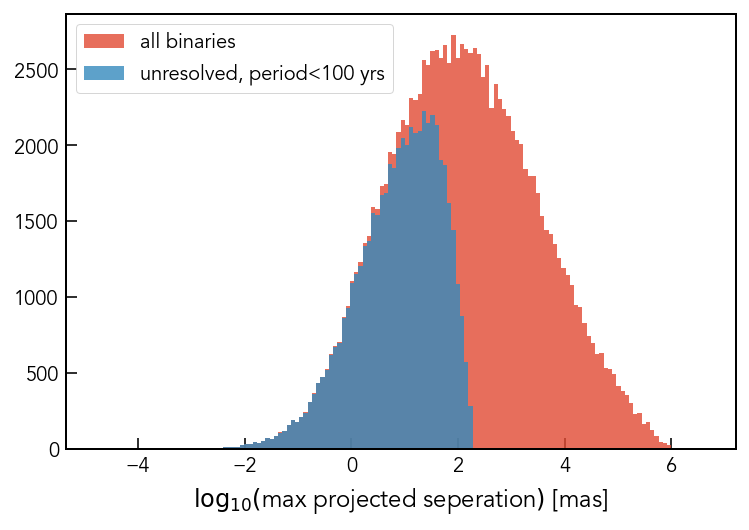

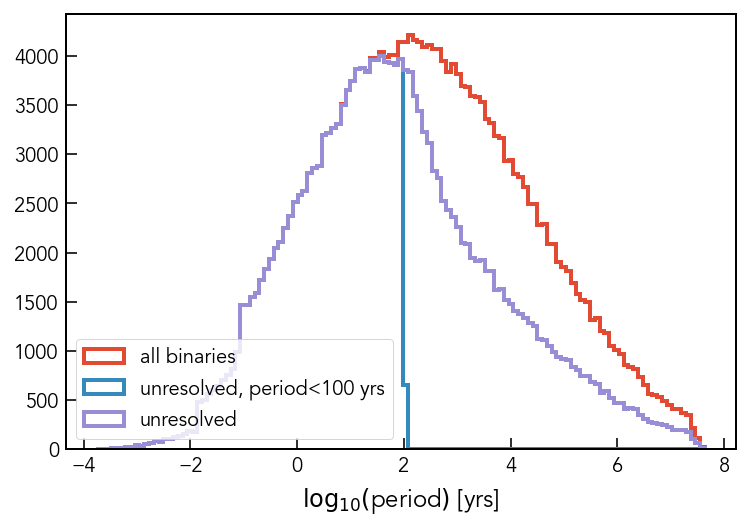

107775  unresolved binaries with period < 100 years 
 out of  882107  sources containing  243377  binaries.


In [364]:
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180) & (periods<30))
ax=plt.gca()
_,bins,_=ax.hist(np.log10(max_proj_sep[binaries]),bins='auto',label='all binaries',alpha=0.8)
ax.hist(np.log10(max_proj_sep[ubins]),bins=bins,label='unresolved, period<100 yrs',alpha=0.8)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($max projected seperation$)$ [mas]')
plt.legend()
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10(periods[binaries]),bins='auto',label='all binaries',histtype='step',lw=2)
ax.hist(np.log10(periods[ubins]),bins=bins,label='unresolved, period<100 yrs',histtype='step',lw=2)
ax.hist(np.log10(periods[ualtbins]),bins=bins,label='unresolved',histtype='step',lw=2)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($period$)$ [yrs]')
plt.legend(loc=3)
plt.show()
print(ubins.size,' unresolved binaries with period < 100 years \n out of ',
      pllxs.size,' sources containing ',binaries.size,' binaries.')

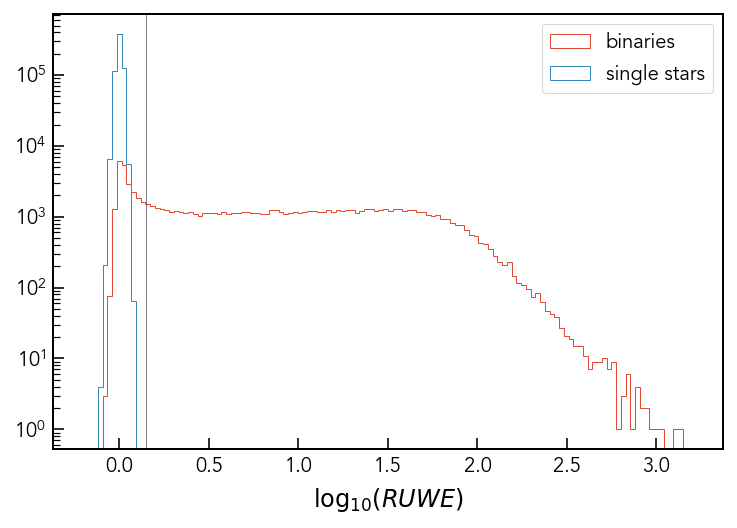

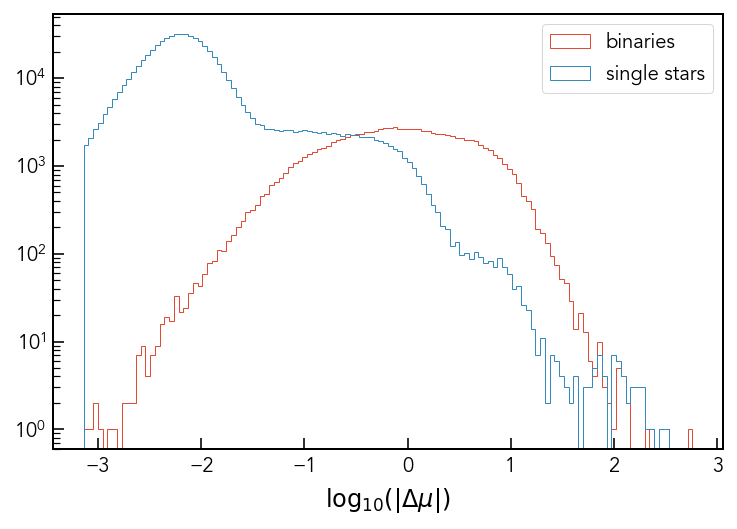

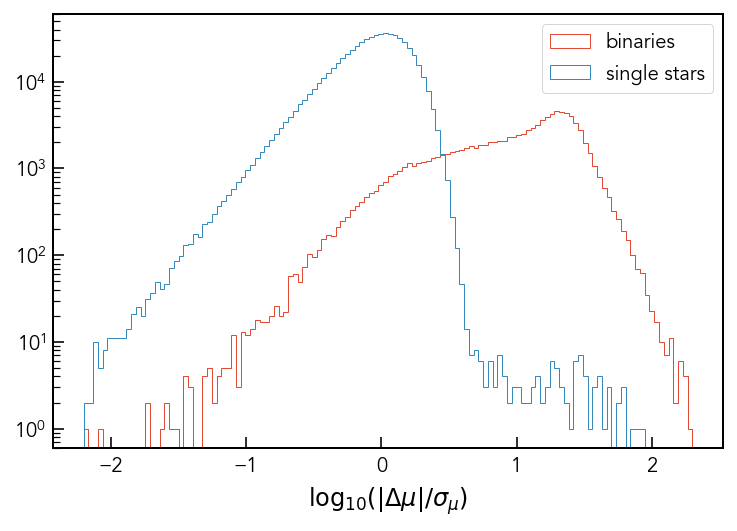

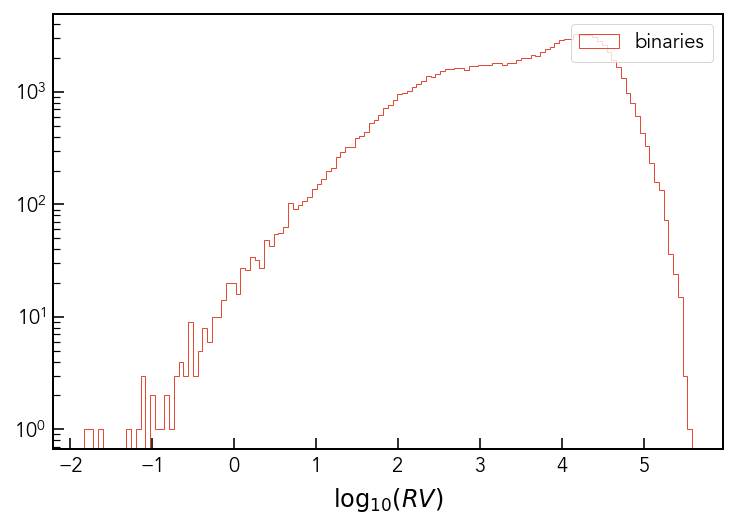

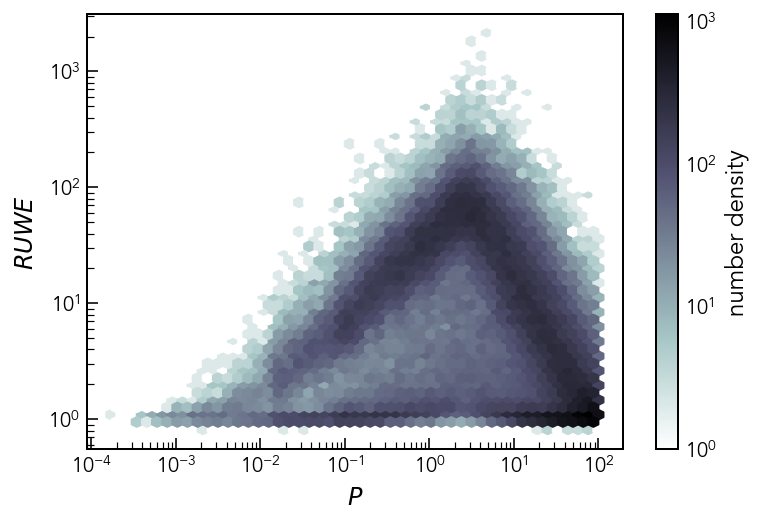

In [362]:
ax=plt.gca()
_,bins,_=ax.hist(np.log10(fuwes[fbinaries]),range=(-0.2,3.2),bins=128,histtype='step',label='binaries')
ax.hist(np.log10(fuwes[fsingles]),bins=bins,histtype='step',label='single stars')
plt.legend()
ax.axvline(np.log10(1.4),c='k',lw=0.5,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(RUWE)$')
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10(fdpms[fbinaries]),bins=128,histtype='step',label='binaries')
ax.hist(np.log10(fdpms[fsingles]),bins=bins,histtype='step',label='single stars')
plt.legend()
#ax.axvline(np.log10(1.4),c='k',lw=0.5,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(|\Delta \mu|)$')
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10((fdpms/fdpm_errs)[fbinaries]),bins=128,histtype='step',label='binaries')
ax.hist(np.log10((fdpms/fdpm_errs)[fsingles]),bins=bins,histtype='step',label='single stars')
plt.legend()
#ax.axvline(np.log10(1.4),c='k',lw=0.5,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(|\Delta \mu|/\sigma_\mu)$')
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10(fdrvs[fbinaries]),bins=128,histtype='step',label='binaries')
#ax.hist(np.log10((fdpms/fdpm_errs)[fsingles]),bins=bins,histtype='step',label='single stars')
plt.legend()
#ax.axvline(np.log10(1.4),c='k',lw=0.5,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(RV)$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uperiods,fuwes[fbinaries],xscale='log',yscale='log',
             cmap='bone_r',bins='log',gridsize=48)
plt.colorbar(im,label='number density')
ax.set_ylabel(r'$RUWE$')
ax.set_xlabel(r'$P$')
plt.show()


In [334]:
def hrextras(ax,xvals=None,yvals=None,
        addcuts=True,addlabels=True,xlim=(-1,5.5),ylim=(20,-3),
            alpha=1,contourcol='k'):
    if ((np.size(xvals)>1) & (np.size(yvals)>1)):
        sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,
                    zorder=2,alpha=alpha,color=contourcol,bw_adjust=0.4)
        # supressing seaborn's habit of adding unwanted labels, could cause bugs?
        ax.set_ylabel('')
        ax.set_xlabel('')
    vd=0.18
    hd=0.05
    if addcuts==True:
        ax.plot([2,2],[20,14],c='k',lw=1,alpha=alpha)
        ax.plot([0,2],[4,14],c='k',lw=1,alpha=alpha)
        ax.plot([2,6],[14,14],c='k',lw=1,alpha=alpha)
        ax.plot([6,-1],[4,4],c='k',lw=1,alpha=alpha)
        ax.plot([1,1],[4,-6],c='k',lw=1,alpha=alpha)
    if addlabels==True:
        ax.text(-0.7,-0.4,'YMS',fontsize=24,
                c=classcols[1],fontweight='bold')
        ax.text(3.5,-0.4,'Giants',fontsize=24,
                c=classcols[2],fontweight='bold')
        ax.text(-0.7,19,'WDs',fontsize=24,
                c=classcols[4],fontweight='bold')
        ax.text(3.5,19,'LMS',fontsize=24,
                c=classcols[3],fontweight='bold')
        ax.text(4.3,7,'MS',fontsize=24,
                c=classcols[0],fontweight='bold')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

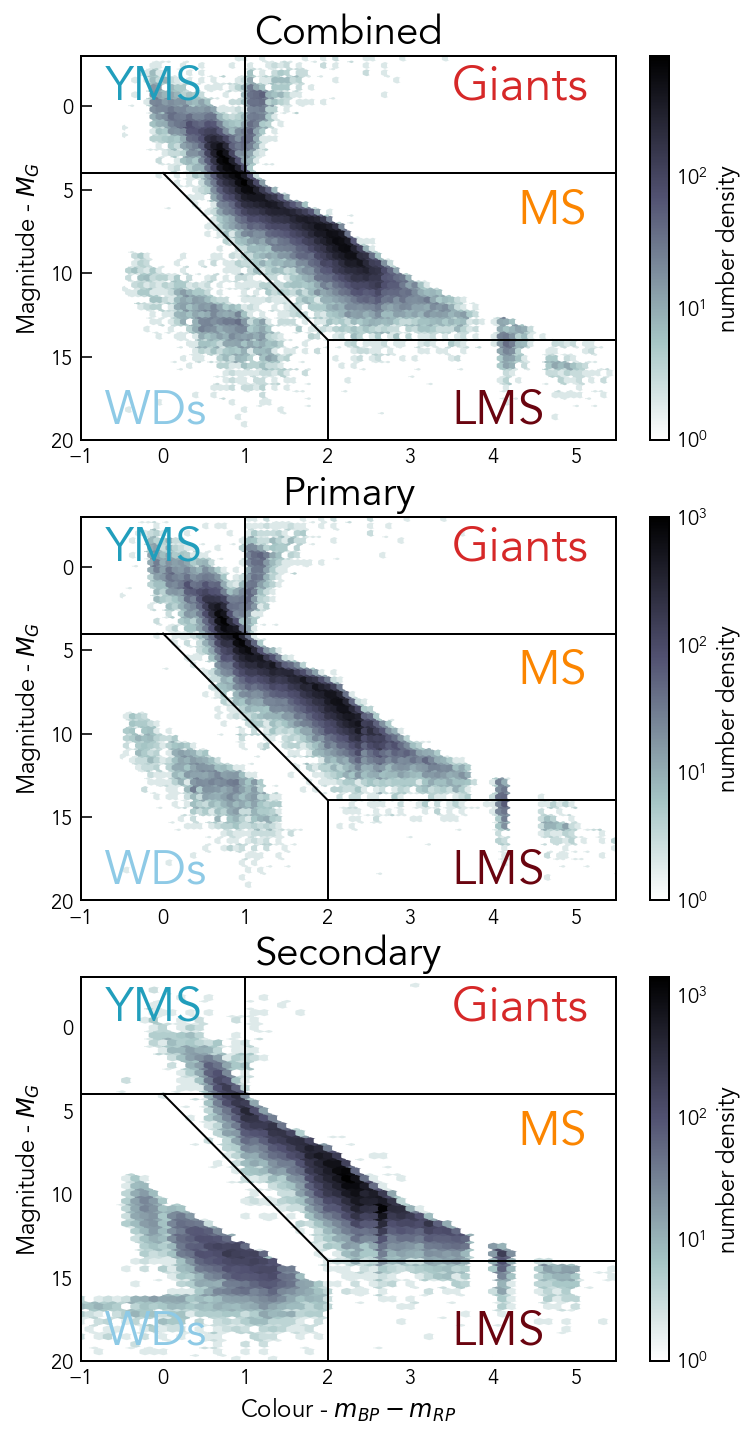

In [363]:
# HR diagram of all binaries, and primary and secondary independantly, seperated by class

fig=plt.figure(figsize=(6,12))
grid=mpl.gridspec.GridSpec(3,1)

ucolscorr=ucols+0.0*np.random.randn(ubins.size)
pucolscorr=pucols+0.0*np.random.randn(pucols.size)
sucolscorr=sucols+0.0*np.random.randn(sucols.size)

ax=plt.subplot(grid[0,0])
hrextras(ax)
ax.set_title('Combined',fontsize=20)
im=ax.hexbin(ucolscorr,uamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
#ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

ax=plt.subplot(grid[1,0])
hrextras(ax)
ax.set_title('Primary',fontsize=20)
im=ax.hexbin(pucolscorr,puamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
#ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

ax=plt.subplot(grid[2,0])
hrextras(ax)
ax.set_title('Secondary',fontsize=20)
im=ax.hexbin(sucolscorr,suamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
ax.set_xlabel(r'Colour - $m_{BP}-m_{RP}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

plt.savefig('plots/HRdiagram.png')
plt.show()

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


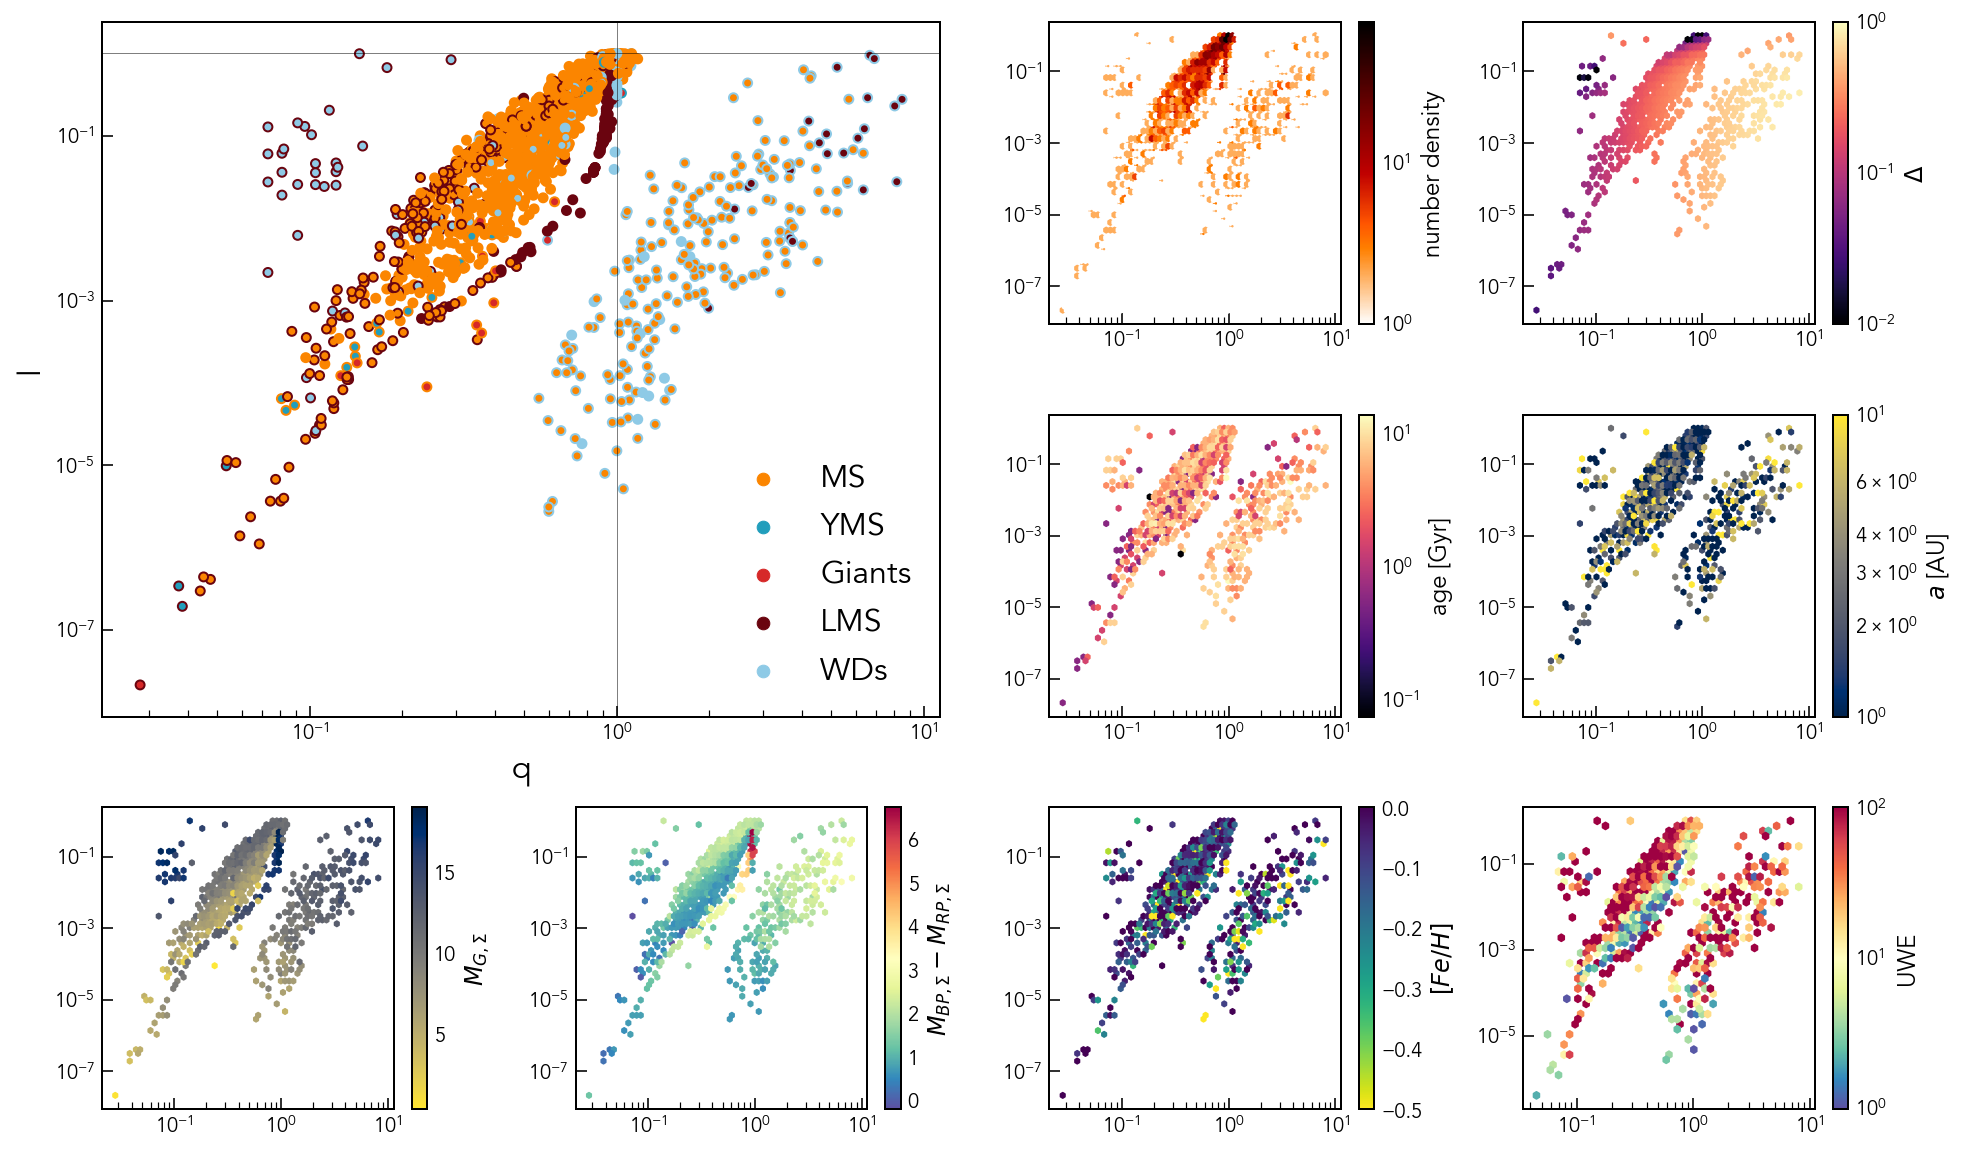

In [336]:
# q and l for all binaries seperated by class, with multiple panels showing properties

fig=plt.figure(figsize=(16,10))
grid=mpl.gridspec.GridSpec(3,4,wspace=0.3,hspace=0.3)

rand=np.arange(uqs.size)
np.random.shuffle(rand)

ax=plt.subplot(grid[0:2,0:2])
ax.scatter(uqs[rand],uls[rand],s=20,c=classcols[primclass][rand],
           edgecolor=classcols[secclass][rand],linewidths=1)
for i in range(5):
    ax.scatter([],[],c=classcols[i],label=classnames[i],s=40)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='k',lw=0.5,alpha=0.5)
ax.axhline(1,c='k',lw=0.5,alpha=0.5)
ax.set_xlabel('q',fontsize=16)
ax.set_ylabel('l',fontsize=16)
plt.legend(frameon=False,fontsize=16)


ax=plt.subplot(grid[0,2])
im=ax.hexbin(uqs,uls,
             xscale='log',yscale='log',cmap='gist_heat_r',bins='log',gridsize=64)
plt.colorbar(im,label='number density')


ax=plt.subplot(grid[0,3])
im=ax.hexbin(uqs,uls,C=udeltas,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='magma',bins='log',
             gridsize=64,vmin=1e-2,vmax=1)
plt.colorbar(im,label=r'$\Delta$')

ax=plt.subplot(grid[2,0])
im=ax.hexbin(uqs,uls,C=uamags,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='cividis_r',gridsize=64)
plt.colorbar(im,label=r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[2,1])
im=ax.hexbin(uqs,uls,C=ucols,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral_r',gridsize=64)
plt.colorbar(im,label=r'$M_{BP,\Sigma}-M_{RP,\Sigma}$')

ax=plt.subplot(grid[2,3])
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral_r',bins='log',gridsize=48,vmax=1e2)
plt.colorbar(im,label='UWE')

ax=plt.subplot(grid[1,2])
im=ax.hexbin(uqs,uls,C=gums['age'][ubins],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='magma',bins='log',
             gridsize=64)
plt.colorbar(im,label='age [Gyr]')

ax=plt.subplot(grid[1,3])
im=ax.hexbin(uqs,uls,C=gums['a'][ubins],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='cividis',bins='log',
             gridsize=64,vmax=10,vmin=1)
plt.colorbar(im,label=r'$a$ [AU]')

ax=plt.subplot(grid[2,2])
im=ax.hexbin(uqs,uls,C=gums['feh'][ubins],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='viridis_r',
             gridsize=64,vmin=-0.5,vmax=0)
plt.colorbar(im,label=r'$[Fe/H]$')

plt.savefig('plots/qlmulti.png')
plt.show()

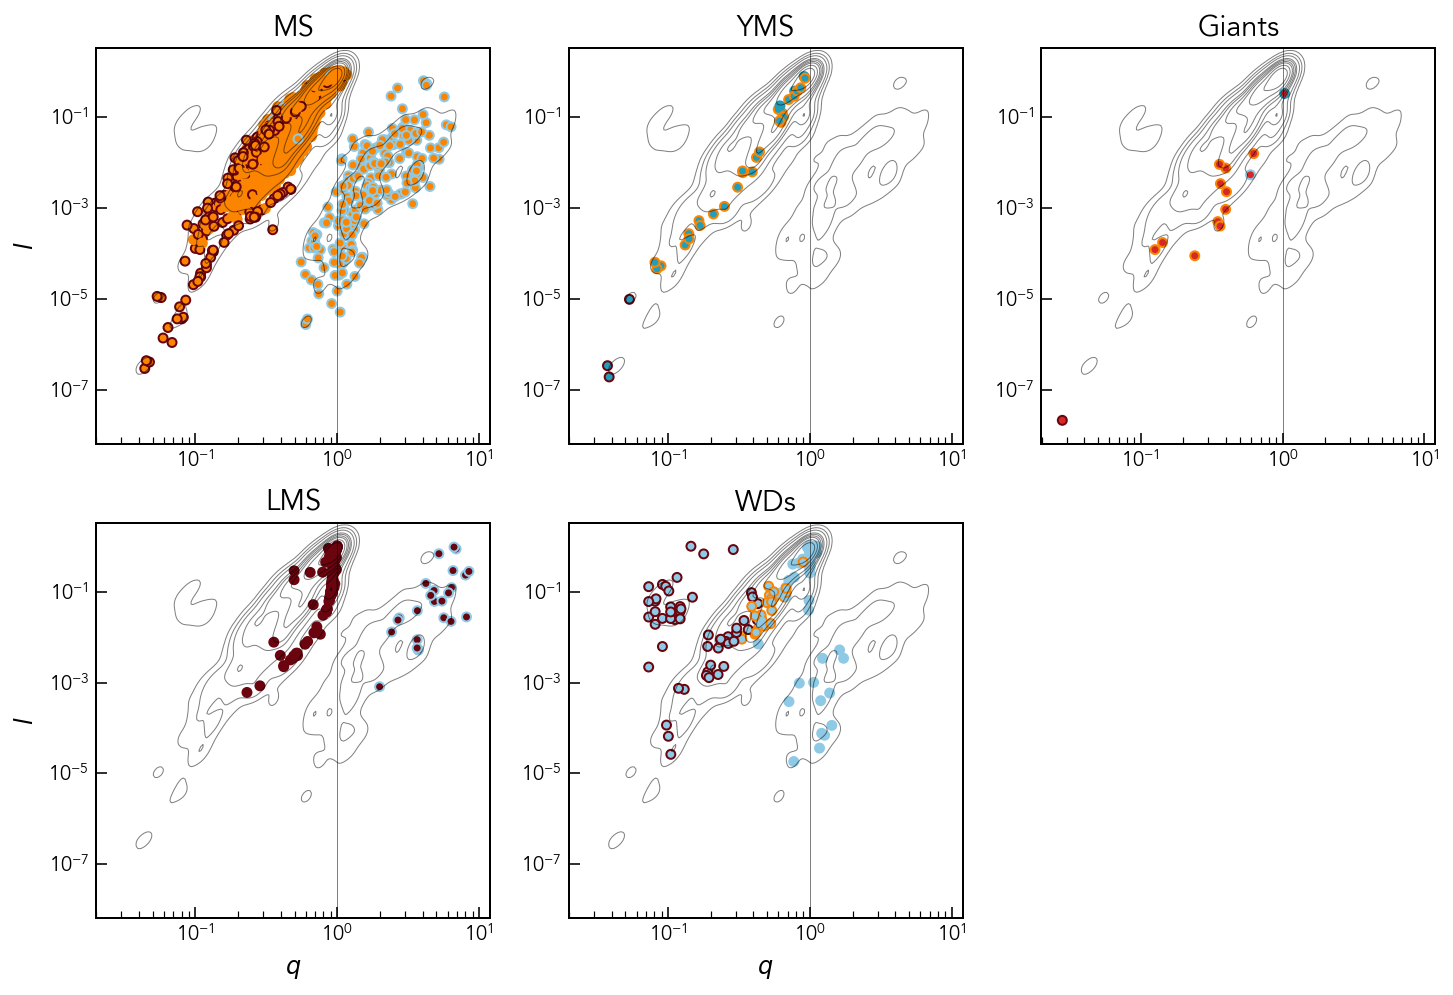

In [337]:
# q and l for all binaries seperated by primary class

fig=plt.figure(figsize=(12,8))
grid=mpl.gridspec.GridSpec(2,3)

for i in range(5):
    
    rand=np.flatnonzero(primclass==i)
    np.random.shuffle(rand)

    ax=plt.subplot(grid[int(i/3),i%3])
    ax.set_title(classnames[i])
    sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
    ax.scatter(uqs[rand],uls[rand],s=20,c=classcols[primclass][rand],
               edgecolor=classcols[secclass][rand],linewidths=1)
    ax.axvline(1,c='k',lw=0.5,alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
    #             xscale='log',yscale='log',cmap='Spectral',bins='log',gridsize=64)
    #plt.colorbar(im,label='median UWE')
    if i>=3:
        ax.set_xlabel(r'$q$')
    if i%3==0:
        ax.set_ylabel(r'$l$')
plt.savefig('plots/qlclass.png')
plt.show()

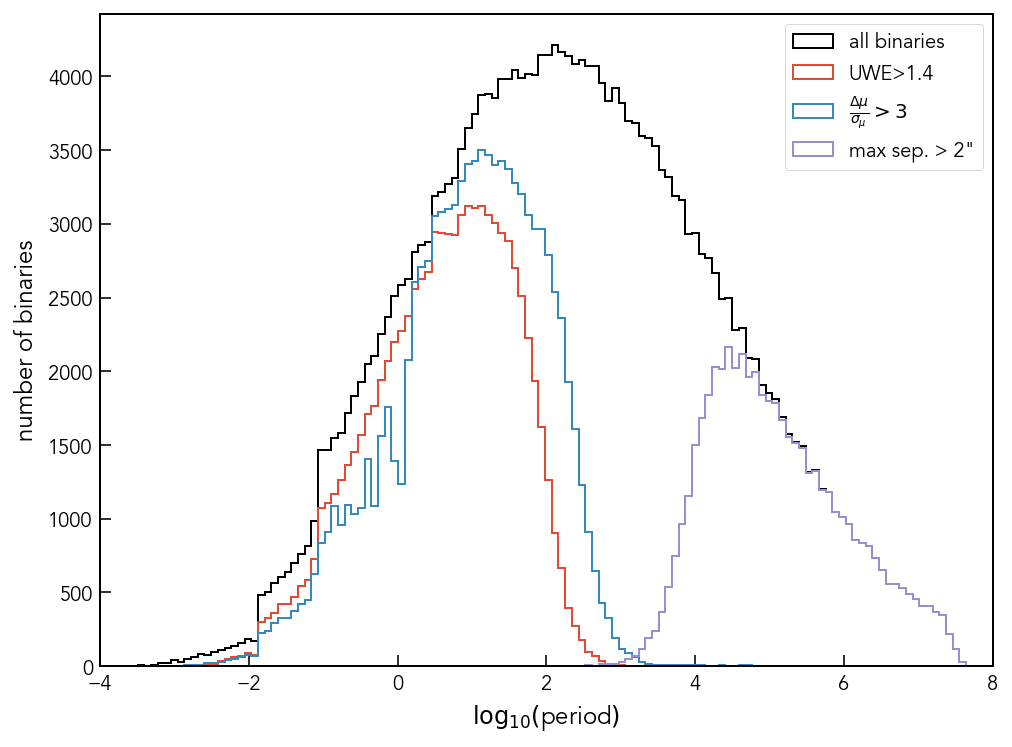

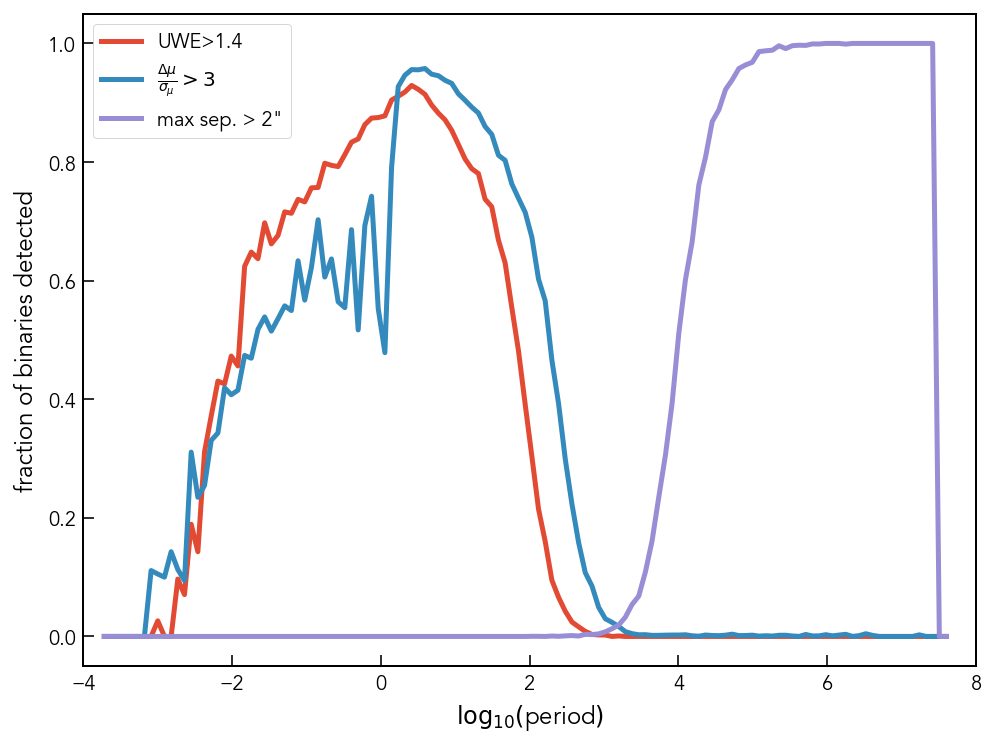

In [360]:
siguwe=binaries[fuwes[fallbinaries]>1.4]
sigsep=binaries[fmaxseps[fallbinaries]>2000]
sigmu=binaries[(fdpms/fdpm_errs)[fallbinaries]>3]
#sigrv=binaries[(fdrvs)[fallbinaries]>10]

fig=plt.figure(figsize=(8,6))
ax=plt.gca()
_,bins,_=ax.hist(np.log10(periods[binaries]),bins='auto',color='k',
                 histtype='step',lw=1,label='all binaries')
ax.hist(np.log10(periods[siguwe]),bins=bins,histtype='step',lw=1,label='UWE>1.4')
ax.hist(np.log10(periods[sigmu]),bins=bins,histtype='step',lw=1,label=r'$\frac{\Delta \mu}{\sigma_\mu}>3$')
ax.hist(np.log10(periods[sigsep]),bins=bins,histtype='step',lw=1,label='max sep. > 2"')
ax.set_xlabel(r'$\log_{10}($period$)$')
ax.set_ylabel(r'number of binaries')
ax.set_xlim(-4,8)
plt.legend()
#ax.hist(np.log10(periods[sigrv]),bins=bins,histtype='step',lw=1)
plt.show()

#pbins=10**np.linspace(-3.5,8,21)
mids=0.5*(bins[1:]+bins[:-1])
fracuwe=np.zeros(mids.size)
fracsep=np.zeros(mids.size)
fracmu=np.zeros(mids.size)
for i in range(2,bins.size-3):
    #print(i)
    inbin=fallbinaries[(periods[binaries]>(10**bins[i])) & (periods[binaries]<(10**bins[i+1]))]
    #print(inbin.size)
    fracuwe[i]=np.flatnonzero(fuwes[inbin]>1.4).size/inbin.size
    fracsep[i]=np.flatnonzero(fmaxseps[inbin]>2000).size/inbin.size
    fracmu[i]=np.flatnonzero((fdpms/fdpm_errs)[inbin]>3).size/inbin.size

fig=plt.figure(figsize=(8,6))
ax=plt.gca()
ax.plot(mids,fracuwe,label='UWE>1.4')
ax.plot(mids,fracmu,label=r'$\frac{\Delta \mu}{\sigma_\mu}>3$')
ax.plot(mids,fracsep,label='max sep. > 2"')
ax.set_xlabel(r'$\log_{10}($period$)$')
ax.set_ylabel(r'fraction of binaries detected')
ax.set_xlim(-4,8)
plt.legend()
#ax.hist(np.log10(periods[sigrv]),bins=bins,histtype='step',lw=1)
plt.show()

In [339]:
print(10**bins)
print(np.sort(periods[binaries]))

[1.20853358e-03 2.76060114e-03 6.30592213e-03 1.44043460e-02
 3.29032264e-02 7.51594211e-02 1.71683425e-01 3.92169043e-01
 8.95814833e-01 2.04627119e+00 4.67420905e+00 1.06770942e+01
 2.43892257e+01 5.57112566e+01 1.27258821e+02 2.90691837e+02
 6.64014828e+02 1.51678044e+03 3.46471614e+03 7.91430167e+03
 1.80782980e+04 4.12954766e+04 9.43294764e+04 2.15472755e+05
 4.92195122e+05 1.12430009e+06 2.56819022e+06 5.86640617e+06
 1.34003786e+07 3.06099070e+07]
[1.20853358e-03 1.69500433e-03 2.32818680e-03 ... 2.57378510e+07
 2.95712276e+07 3.06099070e+07]


/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  after removing the cwd from sys.path.


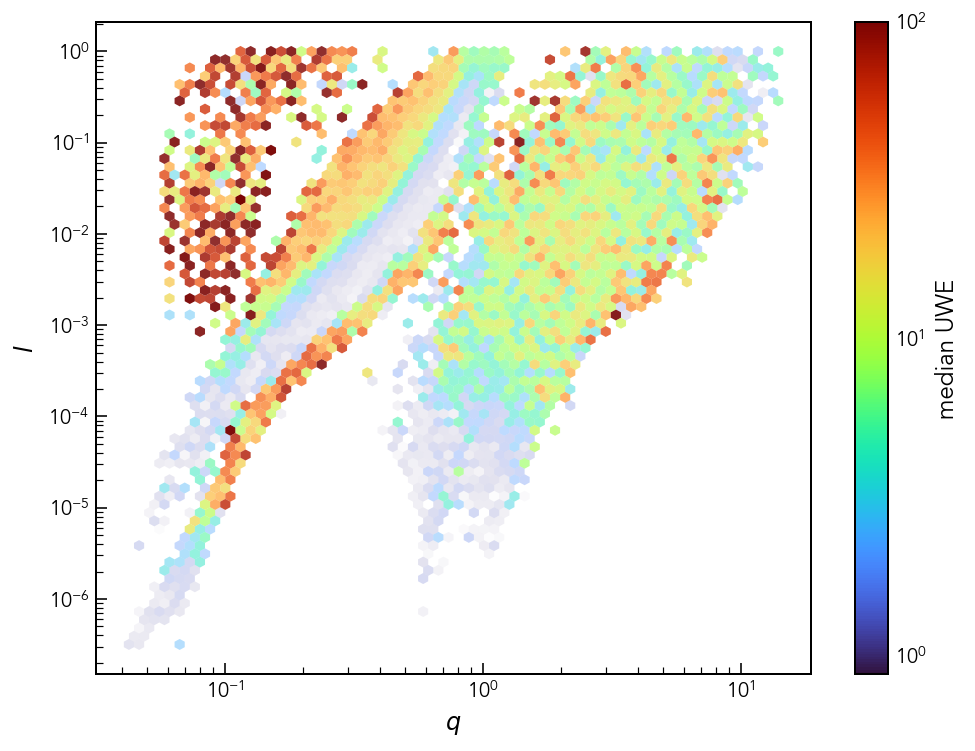

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


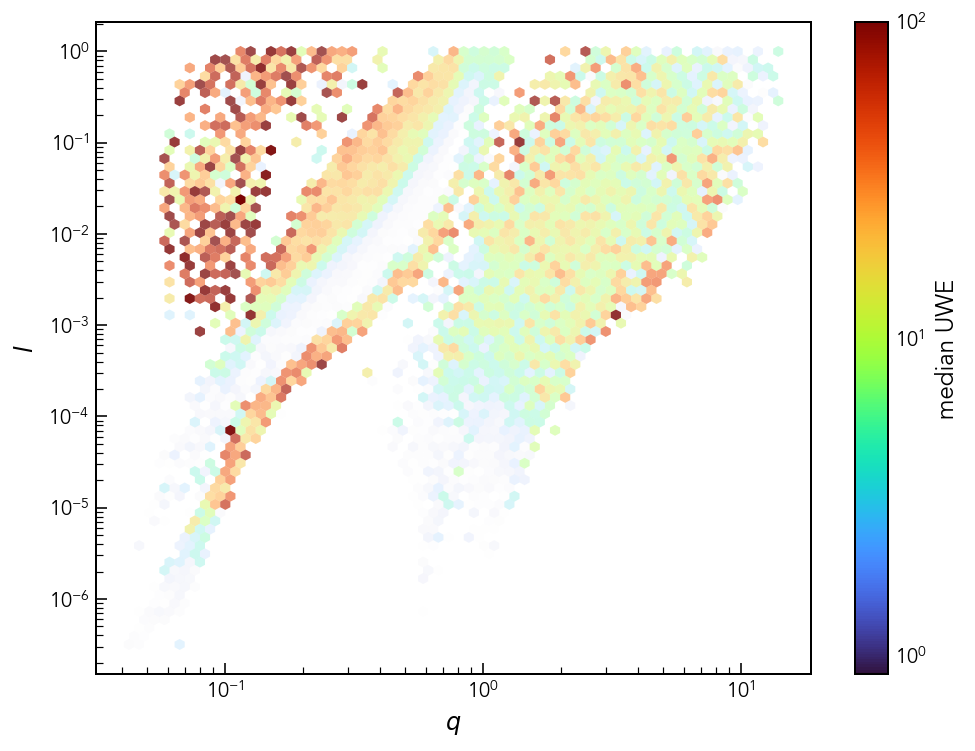

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


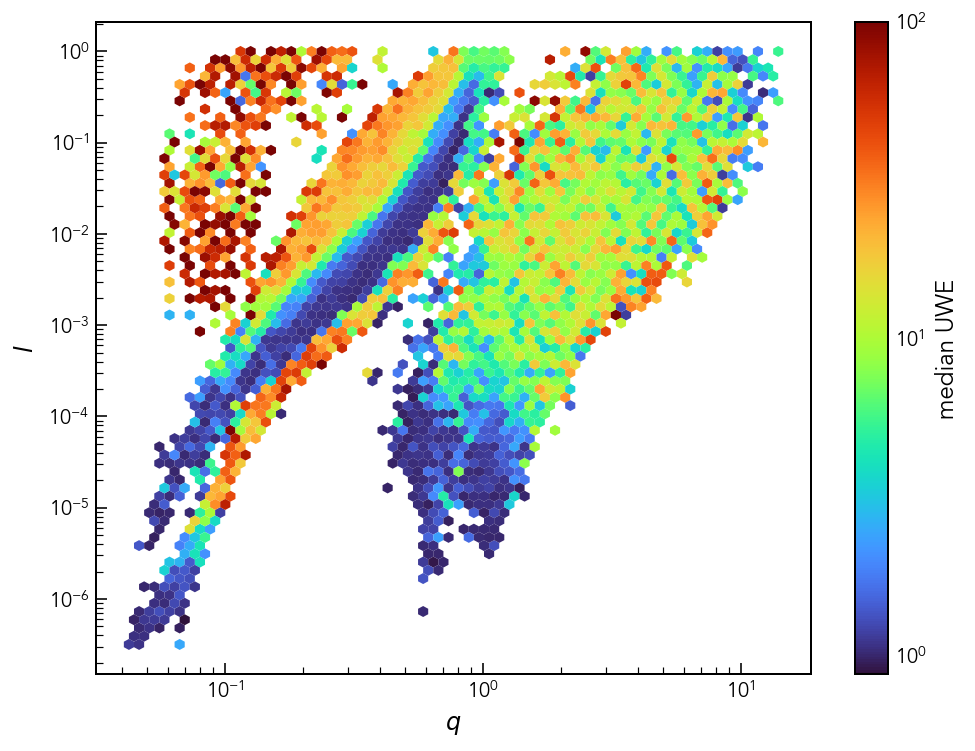

NameError: name 'dfvsv' is not defined

In [390]:
fig=plt.figure(figsize=(8,6))
ax=plt.gca()
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='turbo',bins='log',linewidths=0,vmax=100,gridsize=64)
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
ax.figure.canvas.draw()
counts = im.get_array()         # get the counts (n,)
colors = im.get_facecolors()    # get the facecolors of the patches (n, 4)
colors[:, 3] = np.log10(counts)/np.log10(np.max(counts))   # set the alpha
colors[colors[:, 3]<0, 3]=0
colors[:, 3]=np.sqrt(colors[:, 3])
im.set_facecolors(colors)
plt.show()


fig=plt.figure(figsize=(8,6))
ax=plt.gca()
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='turbo',bins='log',linewidths=0,vmax=100,gridsize=64)
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
ax.figure.canvas.draw()
counts = im.get_array()         # get the counts (n,)
colors = im.get_facecolors()    # get the facecolors of the patches (n, 4)
colors[:, 3] = np.log10(counts)/np.log10(np.max(counts))   # set the alpha
colors[colors[:, 3]<0, 3]=0
im.set_facecolors(colors)
plt.show()

fig=plt.figure(figsize=(8,6))
ax=plt.gca()
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='turbo',bins='log',linewidths=0,vmax=100,gridsize=64)
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

dfvsv

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=uamags,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $M_{G,\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=ucols,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

In [374]:
print(np.log10(np.max(counts)))

2.892197070142049


In [368]:
print(counts)
print(np.log10(counts)/np.log10(np.max(counts)))

[1.13795814 1.08342401 1.0150959  ... 1.9667183  2.31411465 4.84736837]
[0.01940611 0.01203184 0.00224987 ... 0.10156367 0.12598895 0.23701913]


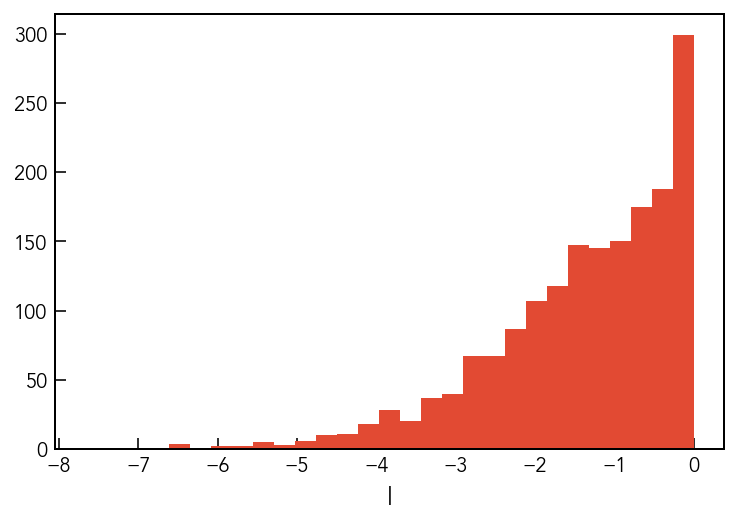

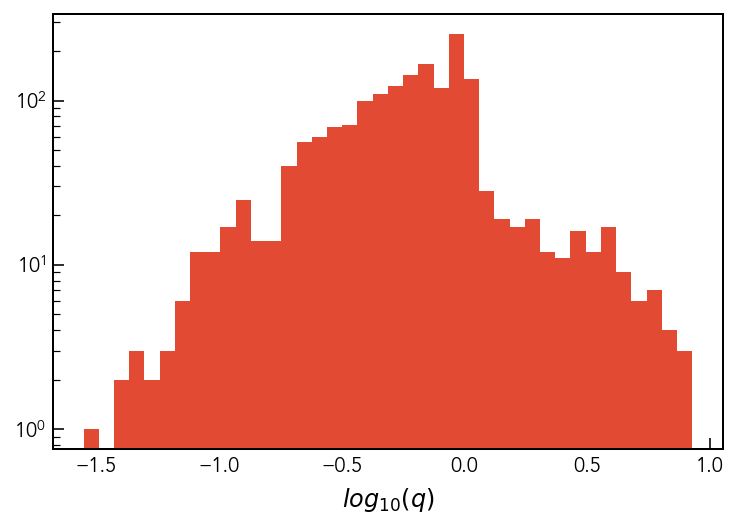

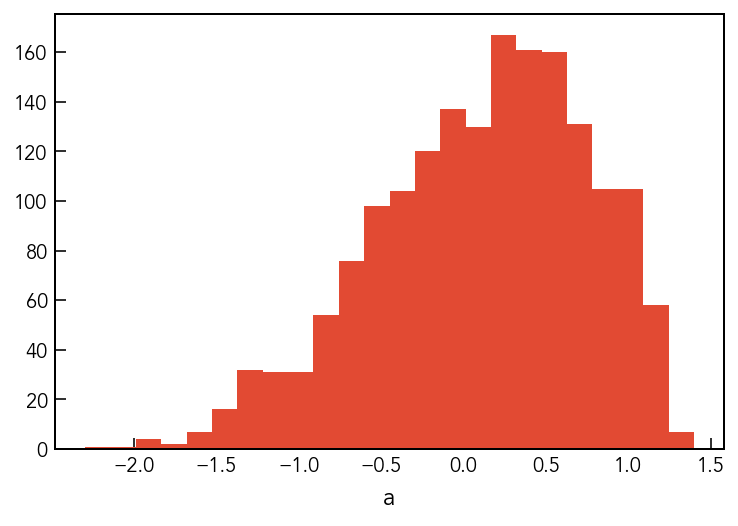

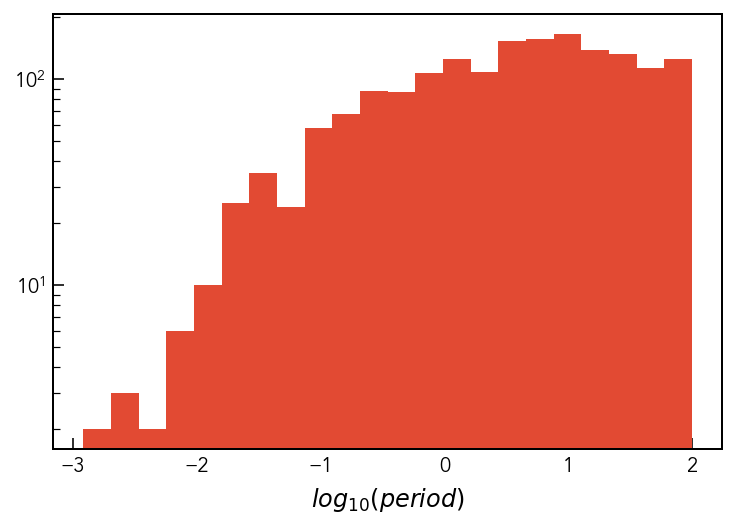

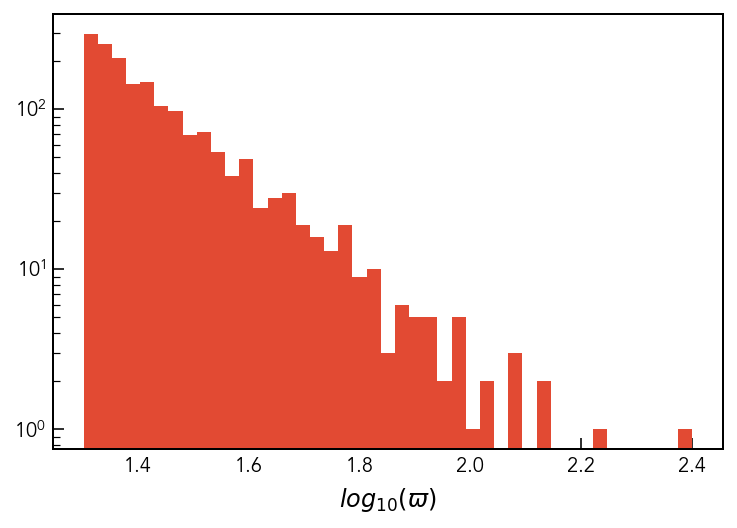

In [341]:
ax=plt.gca()
ax.hist(np.log10(uls),bins='auto')
ax.set_xlabel('l')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uqs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(q)$')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uas),bins='auto')
ax.set_xlabel('a')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uperiods),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(period)$')
plt.show()

ax=plt.gca()
ax.hist(np.log10(upllxs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(\varpi)$')
plt.show()

# testing sensitivity of fits on non-copernican parameters

  0%|          | 0/16 [00:00<?, ?it/s]

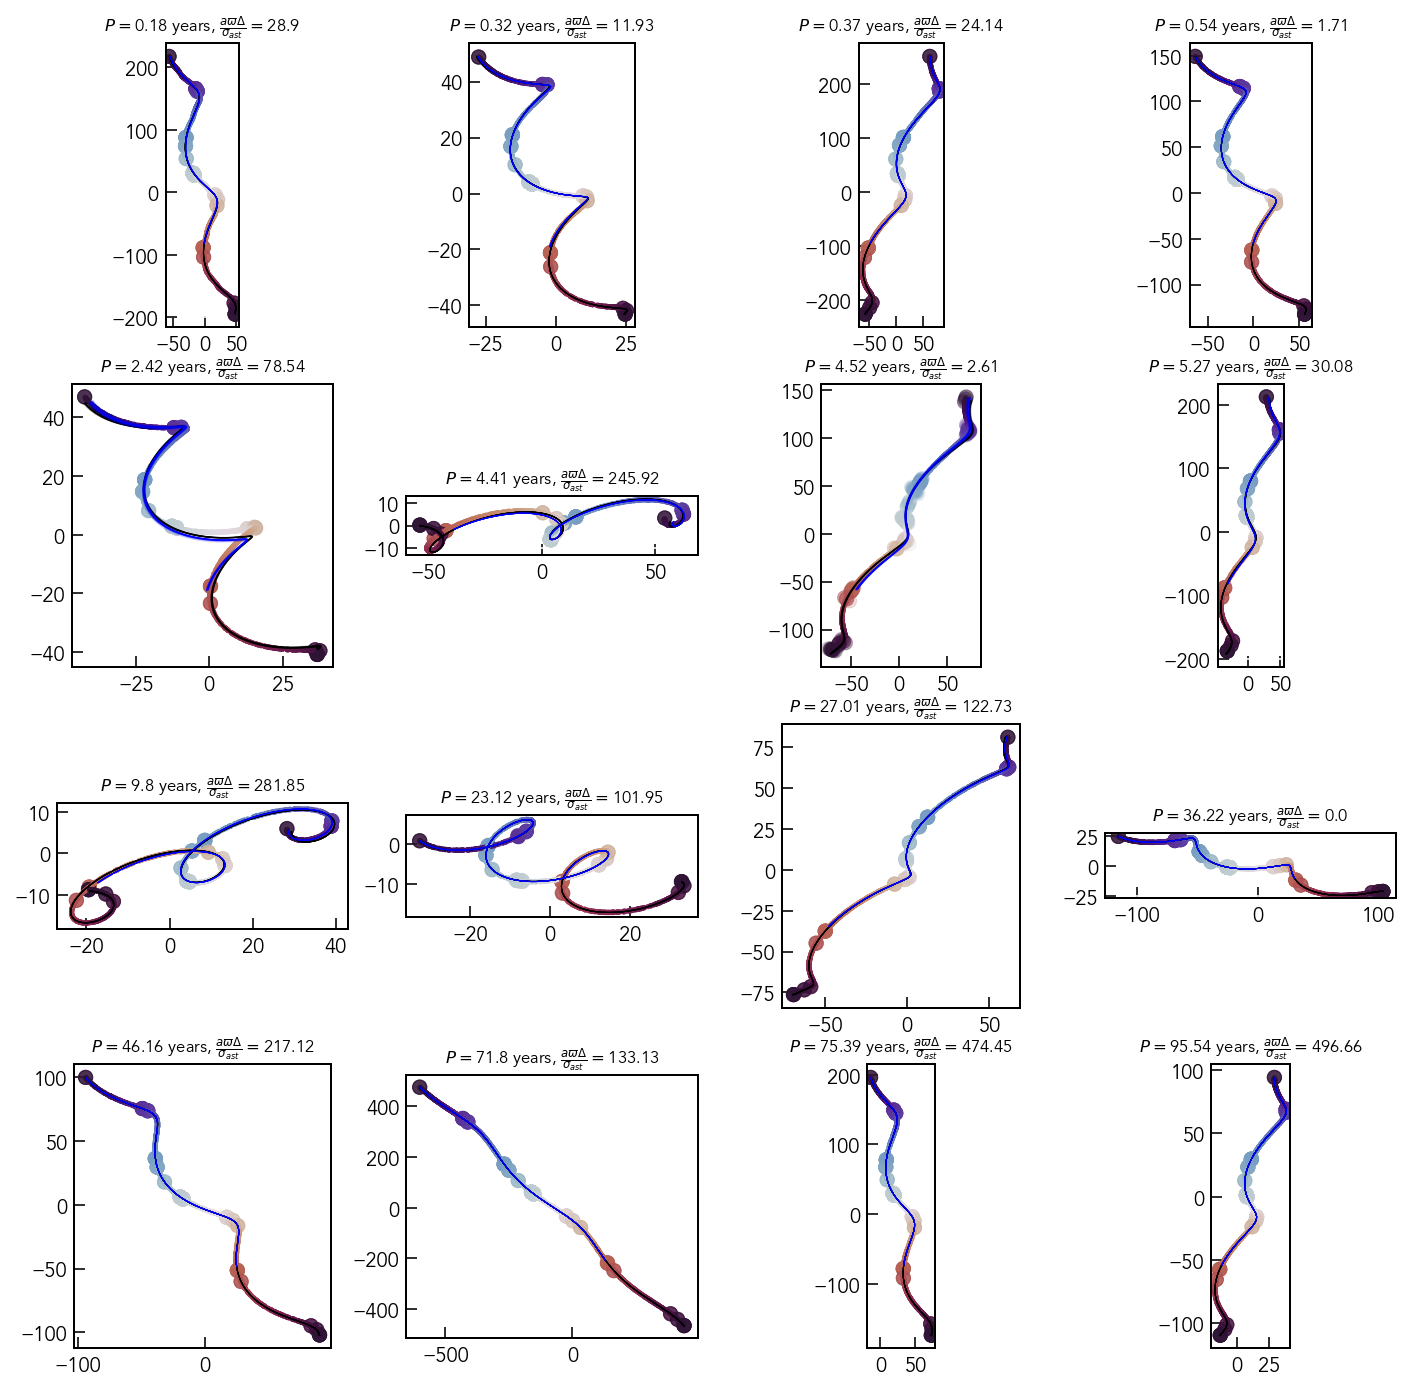

In [320]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    binsig=params.a*params.parallax*astromet.Delta(params)/alError
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    trueRacs,trueDecs=astromet.track(ts,params)

    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

    indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

    fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
    
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fitparams=astromet.params()
    for j in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
        fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
        fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
        fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
        fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts,fitparams)
        ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
    for j in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults2['drac']+np.random.randn()*fitresults2['drac_error']
        fitparams.ddec=fitresults2['ddec']+np.random.randn()*fitresults2['ddec_error']
        fitparams.pmrac=fitresults2['pmrac']+np.random.randn()*fitresults2['pmrac_error']
        fitparams.pmdec=fitresults2['pmdec']+np.random.randn()*fitresults2['pmdec_error']
        fitparams.parallax=fitresults2['parallax']+np.random.randn()*fitresults2['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts[plotts<astromet.tbegin+22/12],
                                       fitparams)
        ax.plot(fitRacs,fitDecs,c='b',alpha=0.2,lw=0.5)
    ax.scatter(rac_obs,dec_obs,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs,plotDecs,c=plotts,s=5,alpha=0.8,cmap='twilight_shifted')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    ax.set_aspect('equal')
    ax.set_title(title,fontsize='small')
    
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

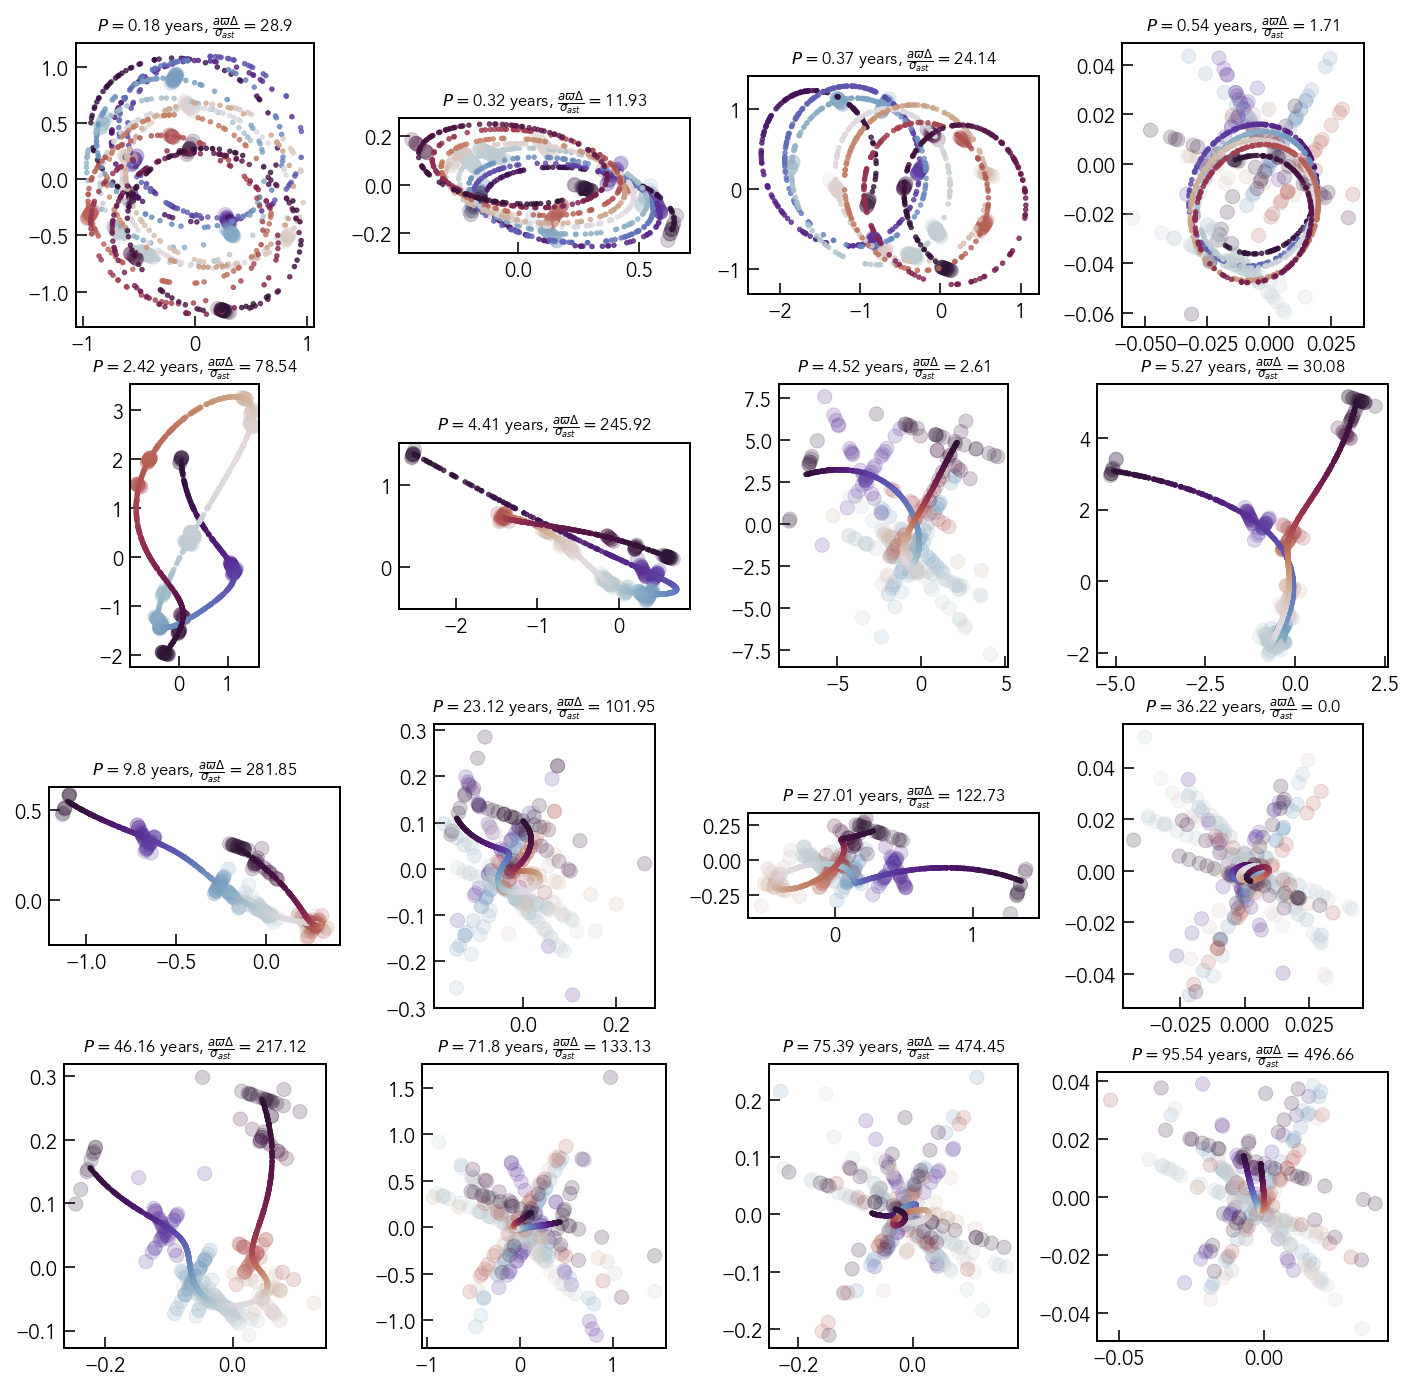

In [321]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    binsig=params.a*params.parallax*astromet.Delta(params)/alError
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    trueRacs,trueDecs=astromet.track(ts,params)

    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

    indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

    fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
    
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fitparams=astromet.params()
    
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=fitresults['drac']
    fitparams.ddec=fitresults['ddec']
    fitparams.pmrac=fitresults['pmrac']
    fitparams.pmdec=fitresults['pmdec']
    fitparams.parallax=fitresults['parallax']
        
    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    rac_fit,dec_fit=astromet.track(t_obs,fitparams)
    
    ax.scatter(rac_obs-rac_fit,dec_obs-dec_fit,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs-fitRacs,plotDecs-fitDecs,c=plotts,s=5,alpha=0.8,cmap='twilight_shifted')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    ax.set_aspect('equal')
    ax.set_title(title,fontsize='small')
    
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

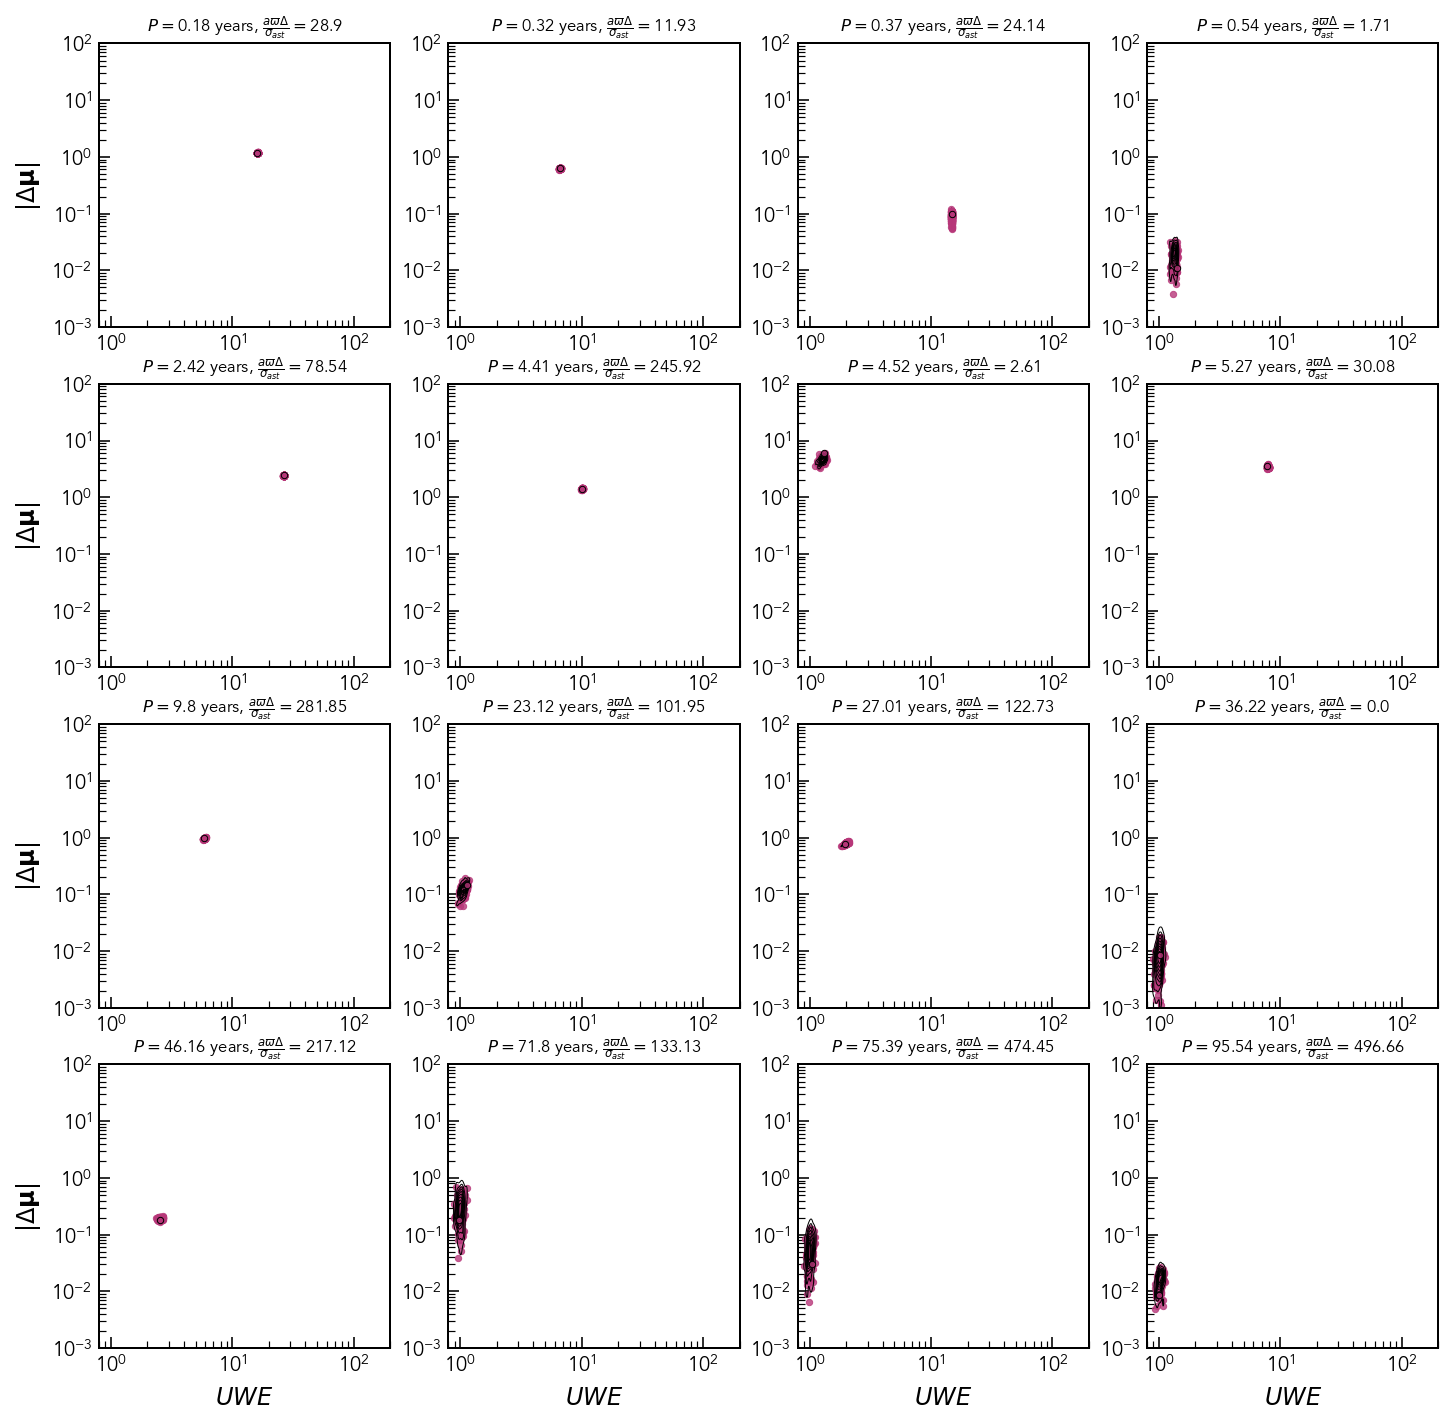

In [322]:
# changing random errors

fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    binsig=params.a*params.parallax*astromet.Delta(params)/alError
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    for j in range(nrand):

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.magma(fitresults2['vis_periods']/20))
        col[3]=0.8
        ecol=None
        zorder=uwe3
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

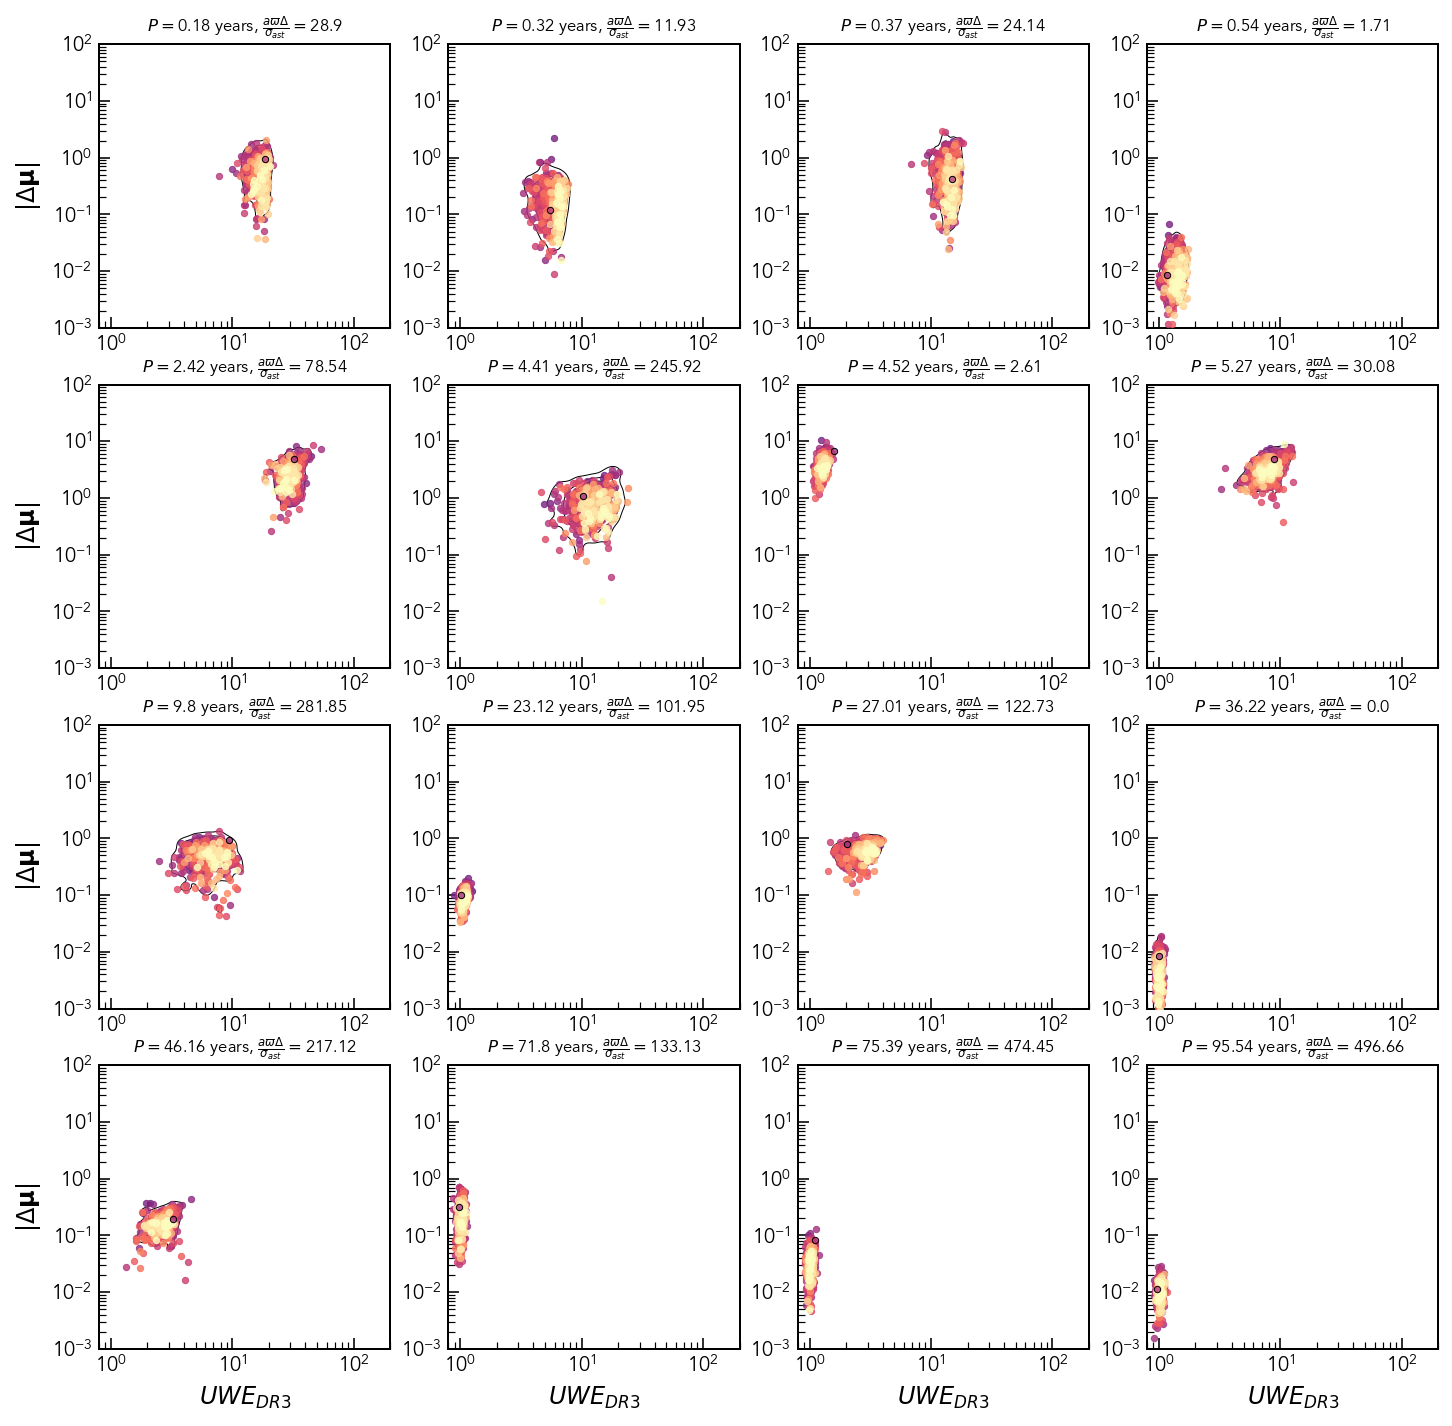

In [323]:
# changing scanning angles

fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=512

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    binsig=params.a*params.parallax*astromet.Delta(params)/alError
    
    for j in range(nrand):
        if j==0:
            params.ra=uras[sel[i]]
            params.dec=udecs[sel[i]]
        else:
            params.ra=360*np.random.rand()
            params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
            
        c=Source(params.ra,params.dec,unit='deg')
        sl=dr3_sl(c, return_times=True, return_angles=True)
        ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
        sort=np.argsort(ts)
        ts=ts[sort]

        phis=np.squeeze(np.hstack(sl['angles']))[sort]
        
        params.ra=uras[sel[i]]
        params.dec=udecs[sel[i]]

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.magma(fitresults2['vis_periods']/20))
        col[3]=0.8
        ecol=None
        zorder=fitresults2['vis_periods']
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE_{DR3}$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

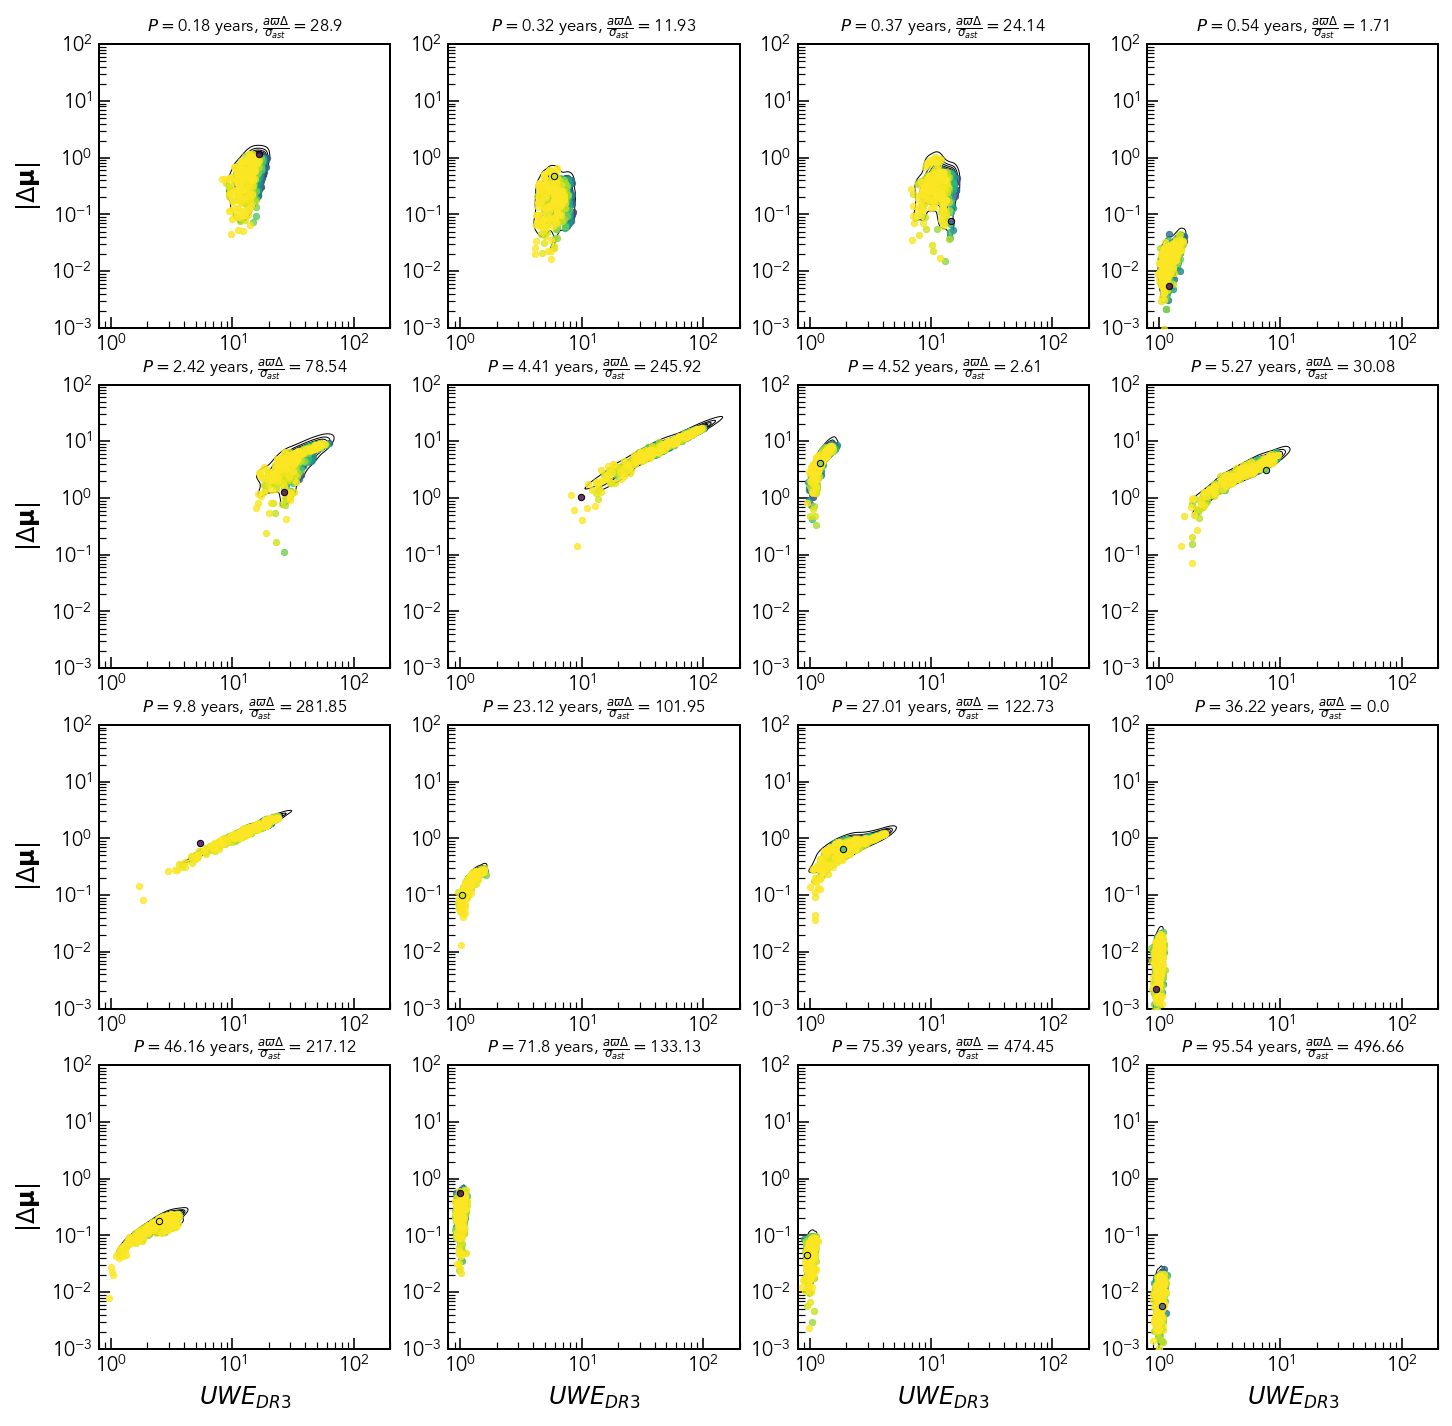

In [325]:
# changing scanning angles

fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=512

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    binsig=params.a*params.parallax*astromet.Delta(params)/alError
    
    for j in range(nrand):
        if j==0:
            params.vtheta=uvthetas[sel[i]]
            params.vphi=uvphis[sel[i]]
            params.vomega=uvomegas[sel[i]]
        else:
            params.vtheta=np.arccos(-1+2*np.random.rand())
            params.vphi=2*np.pi*np.random.rand()
            params.vomega=2*np.pi*np.random.rand()
            
        c=Source(params.ra,params.dec,unit='deg')
        sl=dr3_sl(c, return_times=True, return_angles=True)
        ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
        sort=np.argsort(ts)
        ts=ts[sort]

        phis=np.squeeze(np.hstack(sl['angles']))[sort]
        
        params.ra=uras[sel[i]]
        params.dec=udecs[sel[i]]

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.viridis(np.sin(params.vtheta)))
        col[3]=0.8
        ecol=None
        zorder=2+np.sin(params.vtheta)
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE_{DR3}$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

In [ ]:
for i in tqdm(range(16)):
    
    params=astromet.params()
    params.ra=uras[i]
    params.dec=udecs[i]
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    params.parallax=upllxs[i]
    params.pmrac=upmras[i]
    params.pmdec=upmdecs[i]
    
    params.period=uperiods[i]
    params.a=uas[i]
    params.e=ues[i]
    
    params.l=uls[i]
    params.q=uqs[i]
    
    params.vtheta=uvthetas[i]
    params.vphi=uvphis[i]
    params.vomega=uvomegas[i]
    
    params.tperi=utperis[i]
    
    alError=astromet.sigma_ast(umags[i])
    
    trueRacs,trueDecs=astromet.track(ts,params)
    
    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)
    
    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)
    results=astromet.gaia_results(fitresults)
    
    #print('mag: ',umags[i])
    print('---------------------------------------')
    print('ra, dec, pllx, pmrac, pmdec ',params.ra,params.dec,params.parallax,params.pmrac,params.pmdec)
    print('period ',params.period)
    print('a ',params.a)
    print('e ',params.e)
    print('Delta ',astromet.Delta(params))
    print('UWE ',fitresults["UWE"])
    #print(results)
    
     #optionally plot tracks
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fig=plt.figure(figsize=(8,4))
    grid=mpl.gridspec.GridSpec(1,2)
    ax=plt.subplot(grid[0,0])
    ax.set_title('track')
    fitparams=astromet.params()
    for i in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
        fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
        fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
        fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
        fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts,fitparams)
        ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
    ax.scatter(rac_obs,dec_obs,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs,plotDecs,c=plotts,s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')
    
    ax=plt.subplot(grid[0,1])
    ax.set_title('residual')
    bestparams=astromet.params()
    bestparams.ra=params.ra
    bestparams.dec=params.dec
    bestparams.drac=fitresults['drac']
    bestparams.ddec=fitresults['ddec']
    bestparams.pmrac=fitresults['pmrac']
    bestparams.pmdec=fitresults['pmdec']
    bestparams.parallax=fitresults['parallax']
    bestRacs,bestDecs=astromet.track(plotts,bestparams)
    bestRac_obs,bestDec_obs=astromet.track(t_obs,bestparams)
    
    ax.scatter(rac_obs-bestRac_obs,dec_obs-bestDec_obs,c=t_obs,
               alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs-bestRacs,plotDecs-bestDecs,c=plotts,
               s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_aspect('equal')
    plt.show()
    
    ax=plt.gca()
    ax.scatter(ts,astromet.radial_velocity(ts,params,source='p'))
    print(results)